In [177]:
%matplotlib notebook 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm 
import matplotlib.animation as anim

In [178]:
class Particle():
    
    # init
    def __init__(self, r0,v0,a0,t,m,radius,Id):
        
        self.dt  = t[1] - t[0]
        
        self.r = r0
        self.v = v0
        self.a = a0
        self.m = m
        self.radius = radius
        self.Id = Id
        self.Ep=0
        
        #Usar K =100 N/m3.
        self.K=100
        
        self.rVector = np.zeros( (len(t),len(r0)) )
        self.vVector = np.zeros( (len(t),len(v0)) )
        self.aVector = np.zeros( (len(t),len(a0)) )
        self.MomentumVector=np.zeros((len(t),len(v0)))
        self.EpVector=np.zeros((len(t),1))
        self.EkVector=np.zeros((len(t),1))
        
      #fuerza expresada como f=m*a
        
        self.Force=self.m*self.a
        
     # Cada vez que se avance en el tiempo, debe reiniciar la fuerza y la aceleracion a cero.
   
    def ResetForce(self):
        self.Force[:]=0
        self.a[:]=0
        self.Ep=0
        self.Niter=0
   # Setters
    
      
    
    def SetPosition(self,i,r):
        self.rVector[i] = r
        
    def SetVelocity(self,i,v):
        self.vVector[i] = v
        
    def SetMomentum(self,i,p):
        self.MomentumVector[i] = p
        
    def SetEk(self,i,Ek):
        self.EkVector[i] = Ek
     
    def SetEp(self,i,Ep):
        self.EpVector[i] = Ep 
        
    def GetForce(self,p):
        
        #distancia entre una particuala y la otra
        d=np.linalg.norm(self.r - p.GetPosition())
        compression = self.radius+ p.GetR()- d
        
        if compression > 0:
            Fn=self.K *compression **3/d
            self.Force = np.add(self.Force,Fn*(self.r - p.GetPosition()))
            self.Ep += self.K*compression**4/4 
    # Getters
    
    def GetPosition(self):
        return self.r
    
    def GetPositionVector(self):
        return self.rVector
    
    def GetRPositionVector(self):
        return self.RrVector 
    
    def GetVelocityVector(self):
        return self.vVector
    
    def GetRVelocityVector(self):
        return self.RvVector
    
    def GetMomentumVector(self):
        return self.MomentumVector
    
    def GetKineticEnergy(self):
        return (0.5*self.m*np.linalg.norm(self.v)**2)
    
    def GetPotentialEnergy(self):
        return (0.5*self.Ep/2)
    
    def GetNetForce(self):
        return self.Force
    
    def GetR(self):
        return self.radius
    
    def Evolution(self,i):
        
        self.SetPosition(i,self.r)
        self.SetVelocity(i,self.v)
        self.SetMomentum(i,self.m*self.v)
        
        self.SetEk(i,self.GetKineticEnergy())
        self.SetEp(i,self.GetPotentialEnergy())
        
        self.a=self.Force/self.m
        
         # Euler method
            
        self.r += self.dt * self.v
        self.v += self.dt * self.a
    
    def CheckWallLimits(self,limits,dim=2):
        
        for i in range(dim):
            if self.r[i] + self.radius > limits[i] and self.v[i]>0:
                self.v[i] = -self.v[i]
            if self.r[i] - self.radius < - limits[i] and self.v[i]<0:
                self.v[i] = -self.v[i]
    
  
    def ReduceSize(self,factor):
        
        self.RrVector = np.array([self.rVector[0]]) # initial condition
        self.RvVector = np.array([self.vVector[0]])
        
        for i in range(1,len(self.rVector)):
            if i%factor == 0:
                self.RrVector = np.vstack([self.RrVector,self.rVector[i]])
                self.RvVector = np.vstack([self.RvVector,self.vVector[i]])

In [179]:

def GetParticles(NParticles,Limit,Velo,Dim=2,dt=0.1):
    
    Particles_ = []
    
    for i in range(NParticles):
        
        x0 = np.random.uniform( -Limit+1.0, Limit-1.0, size=Dim )
        v0 = np.random.uniform( -Velo, Velo, size=Dim)
        a0 = np.zeros(Dim)
        if i==0:
            x0=np.array([-5.,0.])
            v0=np.array([20.,0.])
            a0=np.array([0.,0.])
        elif i==1:
            x0=np.array([0.,-1.6])
            v0=np.array([0.,0.])
            a0=np.array([0.,0.])
        elif i==2:
            x0=np.array([-15.,-15.])
            v0=np.array([0.,0.])
            a0=np.array([0.,0.])
        
        
        p = Particle(x0,v0,a0,t,1.,2.0,i)
        
        Particles_.append(p)
        
    return Particles_

In [180]:
Limits = np.array([20.,20.])
dt = 0.001
tmax = 8
t = np.arange(0,tmax+dt,dt)


In [181]:
def RunSimulation(t,NParticles = 3, Velo = 6):
    
    Particles = GetParticles(NParticles,Limits[1],Velo = Velo,dt=dt)
    
    for it in tqdm(range(len(t))): # Evolucion temporal
        #Verificando la tercera ley
        NetForce=np.array([0,0,0])
        
        for i in range(len(Particles)):
            Particles[i].CheckWallLimits(Limits)
            for j in range(len(Particles)):
                if i != j:
                    Particles[i].GetForce(Particles[j])
            Particles[i].Evolution(it)
            Particles[i].ResetForce()     
        
    return Particles

In [182]:
Particles = RunSimulation(t,3,Velo=10)

100%|██████████| 8001/8001 [00:18<00:00, 434.06it/s] 


In [183]:
def ReduceTime(t,factor):
    
    for p in Particles:
        p.ReduceSize(factor)
        
    Newt = []
    
    for i in range(len(t)):
        if i%factor == 0:
            Newt.append(t[i])
            
    return np.array(Newt)

In [184]:
redt = ReduceTime(t,100)

<IPython.core.display.Javascript object>


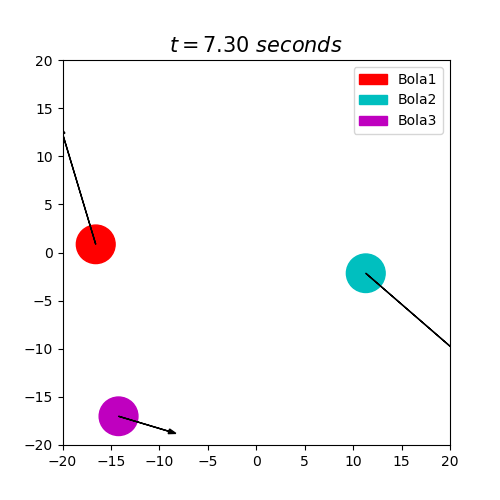

In [185]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1)

colors=["r","c","m"]

def init():
    ax.set_xlim(-Limits[0],Limits[0])
    ax.set_ylim(-Limits[1],Limits[1])


def Update(i):
    
    plot = ax.clear()
    init()
    plot = ax.set_title(r'$t=%.2f \ seconds$' %(redt[i]), fontsize=15)

    for j in range(len(Particles)):
        x = Particles[j].GetRPositionVector()[i,0]
        y = Particles[j].GetRPositionVector()[i,1]
        
        vx = Particles[j].GetRVelocityVector()[i,0]
        vy = Particles[j].GetRVelocityVector()[i,1]
        l="Bola"+str(j+1)
        circle = plt.Circle( (x,y), Particles[j].GetR(), color=colors[j], fill=True, label=l)
        plot = ax.add_patch(circle)
        plot = ax.arrow(x,y,vx,vy,color='k',head_width=0.5)
    
    plot=ax.legend(loc=1)
    return plot

Animation = anim.FuncAnimation(fig,Update,frames=len(redt),init_func=init)

<IPython.core.display.Javascript object>


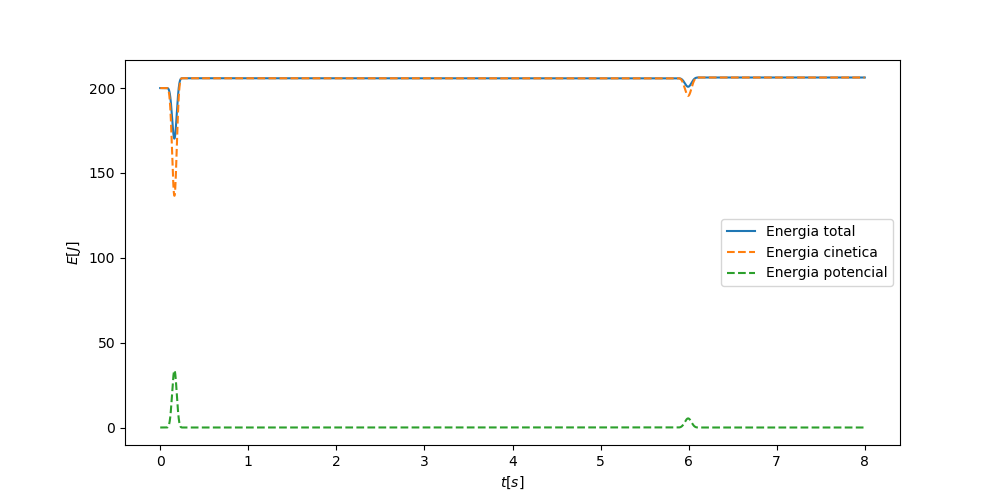

In [198]:
EnergiaK= Particles[0].EkVector
EnergiaP= Particles[0].EpVector
EnergiaTotal= Particles[0].EkVector + Particles[0].EpVector

for i in range(1,len(Particles)):
    EnergiaK=np.add(EnergiaK,Particles[i].EkVector )
    EnergiaP=np.add(EnergiaP,Particles[i].EpVector )
    EnergiaTotal=np.add(EnergiaTotal,Particles[i].EkVector + Particles[i].EpVector )
    
Momentum=Particles[0].GetMomentumVector()

for i in range(1,len(Particles)):
    Momentum=np.add(Momentum, Particles[i].GetMomentumVector())

fig1=plt.figure(figsize=(10,5))
ax1=fig1.add_subplot(1,1,1)
ax1.set_xlabel(r"$t[s]$")
ax1.set_ylabel(r"$E[J]$")
ax1.plot(t,EnergiaTotal,label="Energia total")
ax1.plot(t,EnergiaK,"--",label="Energia cinetica")
ax1.plot(t,EnergiaP,"--",label="Energia potencial")
ax1.legend(loc=0)

# 0.2 Tiempo libre medio

In [187]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc 
import os.path as path
import wget

In [188]:
url = 'https://raw.githubusercontent.com/asegura4488/Database/main/MetodosComputacionalesReforma/EnergiaPotencialGas2D.txt'
if not path.exists(url):
    Path_ = wget.download(url)
    print('Descargado')
else:
    Path_ = file

Descargado


In [189]:
data = np.loadtxt(Path_)

tiempo= data[:,0]   # escribir la fecha en unidades de años
energiap= data[:,1] 
print(tiempo,energiap)

[0.000e+00 1.000e-03 2.000e-03 ... 7.997e+00 7.998e+00 7.999e+00] [424.88697365 424.17895817 422.15355189 ...   0.           0.
   0.        ]


In [190]:
ii=tiempo >0.01
mean=np.mean(energiap[ii])
energiap1=energiap[ii]-mean
tiempo1=tiempo[ii]

<IPython.core.display.Javascript object>


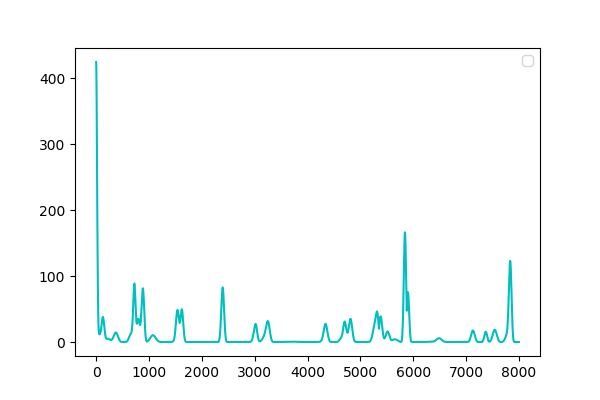

No handles with labels found to put in legend.


In [197]:
fig2=plt.figure(figsize=(6,4))
ax2=fig2.add_subplot(1,1,1)
plt.plot(energiap,color="c")
ax2.legend(loc=0)

In [192]:
N=len(energiap1)
fft=np.fft.fft(energiap1)
Frec=np.fft.fftfreq(N,1)
ffta=np.abs(fft)

<IPython.core.display.Javascript object>


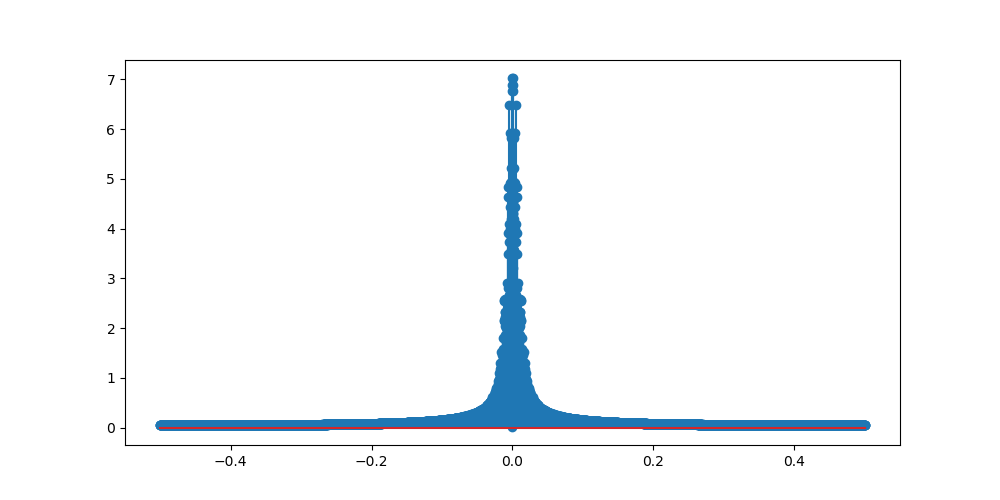

<StemContainer object of 3 artists>

In [193]:
fig3=plt.figure(figsize=(10,5))
plt.stem(Frec,2.*ffta/N,use_line_collection="True")

In [194]:
ii=np.argmax(ffta)
fo=Frec[ii]
T=(1./fo)
print(fo)

ii_a=np.abs(Frec)>fo
ii_b=np.abs(Frec)<fo

fft[ii_a | ii_b]=0
FFTA=np.abs(fft)

0.0013768932281887595


<IPython.core.display.Javascript object>


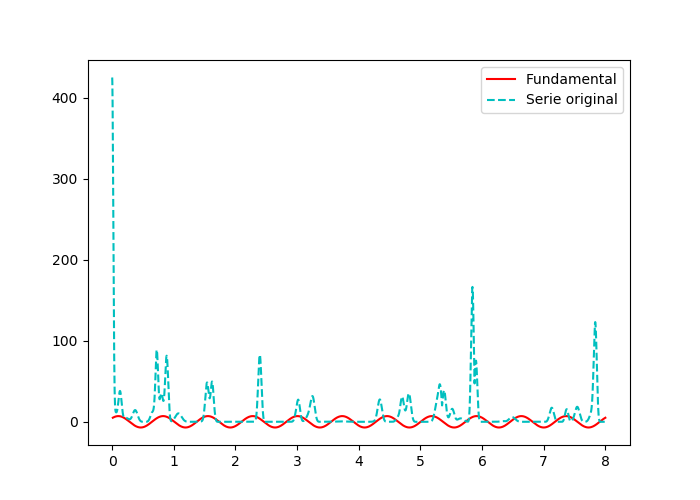

In [200]:
energia_f=np.fft.ifft(fft)

fig4=plt.figure(figsize=(7,5))
ax4=plt.subplot(1,1,1)

plt.plot(tiempo1,np.real(energia_f),color="r",label="Fundamental")

plt.plot(tiempo,energiap,"--",color="c",label="Serie original")
plt.legend(loc=0)